## Optimization and A Handwaving Introduction to Compressive Sensing

In this page we shall demosntrate how to use Scipy's optimization package and use it to cheat Nyquist rule! 

### Basics of Optimization using Scipy Optimization Package

Lets optimize $f(x) = \exp{(x-2)^2}$

In [1]:
import numpy as np
import matplotlib.pyplot as mp 
import scipy as sp
import cvxpy as cp
from scipy import optimize
from scipy import fftpack

def f(y):
    return -np.exp(-(y-2)**2)
result = optimize.minimize_scalar(f)

print(result)

     fun: -1.0
    nfev: 7
     nit: 6
 success: True
       x: 1.9999999955459995




We can also use Python's minimize or maximize function (with the ``key'' option) to optimize the function!




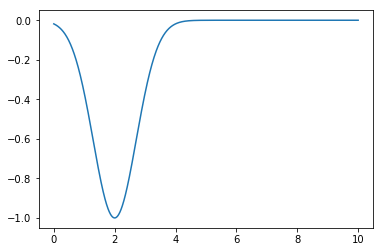

2.002002002


In [2]:
y = np.linspace(0,10,1000)
mp.plot(y,-np.exp(-(y-2)**2)); mp.show()
#print(max(x, key=lambda x: np.sinc(x-20)))

print(min(y, key=lambda x: -np.exp(-(x-2)**2)))

Now let us optimize the infamous Rosenbrock function.

$f(x,y) = 0.5*(1-x)^2 + (y - x^2)^2$

In [3]:
def f(x):   # The rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2
optimize.minimize(f, [20,-10], method="CG")  


     fun: 6.061480952893705e-11
     jac: array([ -1.36249187e-06,  -4.53529277e-06])
 message: 'Optimization terminated successfully.'
    nfev: 68
     nit: 8
    njev: 17
  status: 0
 success: True
       x: array([ 0.99998947,  0.99997667])

What happens if we change the seed to something very far from the solution point?

In [4]:
optimize.minimize(f, [200,-100], method="CG")

     fun: 66957.93725135528
     jac: array([-13070.51464844,   -517.16601562])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 40
     nit: 2
    njev: 7
  status: 2
 success: False
       x: array([-12.62350447, -99.2300757 ])

#### Constrained Optimization

In this let us give the constraints as well. 

For example: $f(x) = 2xy + 2x - x^2 - 2 y^2$.

Constraints are as follows:

$x^3−y = 0$

$y−1 \geq 0$

In [5]:
def func(x, sign=1.0):
    """ Objective function """
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)
    
cons = ({'type': 'eq',
          'fun' : lambda x: np.array([x[0]**3 - x[1]])},
        {'type': 'ineq',
          'fun' : lambda x: np.array([x[1] - 1])})

res = optimize.minimize(func, [-1.0,1.0], args=(-1.0,),
                method='SLSQP', options={'disp': True})
print(res.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
[ 1.99999999  1.        ]


In [6]:
res = optimize.minimize(func, [-1.0,1.0], args=(-1.0,), 
                constraints=cons, method='SLSQP', options={'disp': True})

print(res.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.0000001831248646
            Iterations: 9
            Function evaluations: 41
            Gradient evaluations: 9
[ 1.00000009  1.        ]


### COMPRESSIVE SENSING

Now lets discuss about compressive sensing. Lets assume that we have some signal recorded (following Nyquist rate); lets call it $x$. Its size is $N$. 

In the following signal we are using 500 samples and two sinusoids. You can note that one of them takes 10 samples per cycle; hence there are 50 cycles. So Nyquist will want us to have at least 100 samples in order to be able to know whats in the signal!

However if we look the signal through DCT then there are just two samples. Mark that we are using DCT and not FFT; because then we dont have to deal with complex numbers!

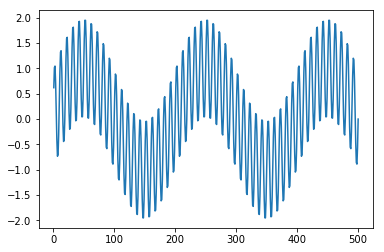

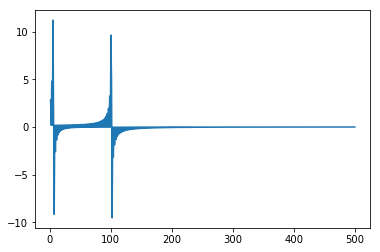

([<matplotlib.lines.Line2D at 0x116422a58>], None)

In [17]:
n = np.linspace(1,500,500)

#two harmonics signal
xx = np.sin(2*np.pi*n/10) + np.sin(2*np.pi*n/200) # + np.sin(2*np.pi*n/50)
mp.plot(n,xx), mp.show()
mp.plot(n,fftpack.dct(xx, norm='ortho')), mp.show()

Lets assume that we only consider $n$ of this ($n << N$). 

For this lets define a sparsifying vector sp which has only $n$ 1's and rest zeros placed in random places. 

So sparsed data $xp = xx*sp$.

The trick is that these $n$ samples are randomly taken.

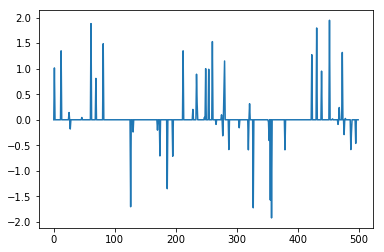

([<matplotlib.lines.Line2D at 0x11963e780>], None)

In [55]:
N = len(xx) #length of actual N
n = 50 #number of nonzero samples in our sparse signal
sp = np.array([1] * n + [0] * (N-n)) #n 1's and (N-n) 0's
np.random.shuffle(sp)  

xp = xx*sp
mp.plot(xp), mp.show()

### Using Optimization

The trick of compressive sensing is that we try to use optimization in order to know the unknown from what is known!

So let us think what we know. 

1- We know $xp$ the random-subNyquist-sampled signal and $sp$.
2- We know that the signal is sparse in DCT domain. 

So lets try to look into the DCT domai. Lets assume that the DCT of the signal is $XX$. So IDCT of it should give us $xp$ back. 

Lets define an optimization problem to do this. 

         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 57742
         Gradient evaluations: 115


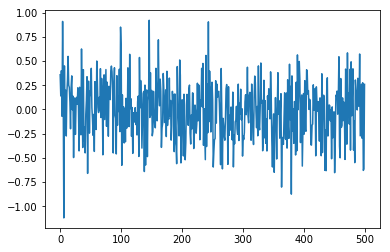

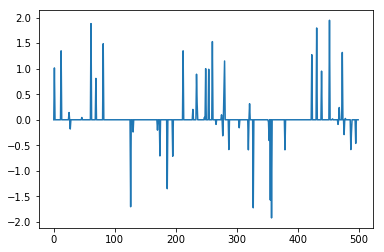

([<matplotlib.lines.Line2D at 0x1197e0128>], None)

In [56]:
XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    xd = fftpack.idct(XX, norm='ortho') #derived x from X
    xdn = xd*sp
    return np.linalg.norm((xdn - xp), ord=2)

seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, options={'disp': True})

xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()

### Redfining the Optimization
Hmmmm. Enen though the optimization has not finished doing its job if we look at the result we seem to have achieved what we asked for!

The reconstructed signal $xrecon$ looks exactly like $xp$. 
So we did achieve what we wanted (theoritically speaking) but we want more. 

What else can we do? 

Lets add a condition that we want to optimize $||xrecon - xp ||$ but we also want to keep XX sparse, i.e. the $L-0$ norm of $XX$ should be less than $n$.

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.00583100801974747
            Iterations: 101
            Function evaluations: 50982
            Gradient evaluations: 101


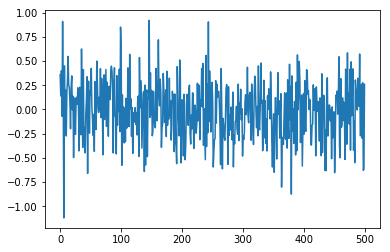

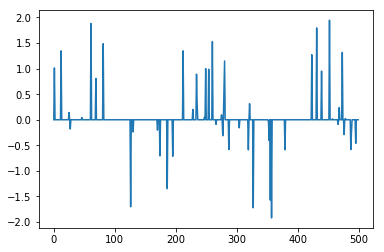

([<matplotlib.lines.Line2D at 0x1183722e8>], None)

In [62]:
XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    xd = fftpack.idct(XX, norm='ortho') #derived x from X
    xdn = xd*sp
    return np.linalg.norm((xdn - xp), ord=1)

cons = ({'type': 'ineq',
          'fun' : lambda XX: n - np.linalg.norm(XX,ord=0)})

#seed = np.random.rand(N)
seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, constraints=cons, options={'disp': True})

xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()

### Re-redfining the Optimization: L1 Magic!!
Hmmmm. It seems its not working the way we want it to work. What else can we do?

It seems achieving $xrecon = xp$ is an easy task, because its sparse anyway. 

So lets keep this as a condition (instead of making it the cost-function). And minimize $XX$. And let us use $L1$ norm here so as to keep the error under control. Remember that even though $L2$ norm is smooth, it has a square and blows up the error. So in wildly uknown problems like what we dealing with here, its better to use $L1$ norm. 

In [63]:
XX = np.random.rand(N)
def cost_cs(XX):   #given the measured xp and a generic X find the L1 norm
    return np.linalg.norm(XX, ord=1) 

cons = ({'type': 'eq',
          'fun' : lambda XX : np.linalg.norm(xp - fftpack.idct(XX, norm='ortho')*sp, ord = 2)})

seed = np.random.rand(N)
#seed = np.zeros(N)

CS = optimize.minimize(cost_cs, seed, constraints=cons, options={'disp': True})

Iteration limit exceeded    (Exit mode 9)
            Current function value: 59.64657775925451
            Iterations: 101
            Function evaluations: 51005
            Gradient evaluations: 101


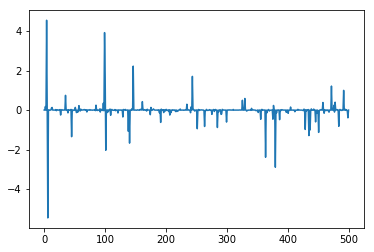

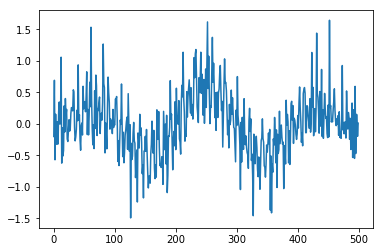

([<matplotlib.lines.Line2D at 0x1168cde80>], None)

In [64]:
xrecon = fftpack.idct(CS.x, norm='ortho')
mp.plot(CS.x), mp.show()
mp.plot(xrecon), mp.show()


## Conclusion

Unfortunately the optimization process did not end. We need more iteration. However, we seem to have got something which looks pretty much like the signal we have started with. It is noisy but it is encouraging given the fact that we have got only half the number of samples as Nyquist would have wanted. 

This is the starting of Compressive Sensing (CS). We have learnt two things.

1- It is easy to cheat Nyquist if the signal is sparse in some other linearly transferable domain. 
2- Redefining the optimization problem can help us achieve magical results. 

The hard-core CS involvs more interesting objective functions and constraints to achieve even more interesting magical results. 